In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp crossing

In [ ]:
from chewc.core import *
from chewc.meiosis import *
import torch

## Crossing
> Using gamete operations to produce new individuals

In [ ]:
#| export
from chewc.core import *
from chewc.meiosis import *
from chewc.trait import *
import torch
def double_haploid_operation(gamete):
    return gamete.repeat(2, 1, 1)

def make_DH(genetic_map, individual):
    haploid_line = simulate_gametes(genetic_map, individual)
    return double_haploid_operation(haploid_line)

In [ ]:
#| export

def cross_operation(egg, pollen):
    return torch.stack((egg, pollen), dim=0).squeeze(1)

def make_cross(genetic_map, mother, father):
    egg = simulate_gametes(genetic_map, mother)  # Simulating gametes for the mother
    pollen = simulate_gametes(genetic_map, father)  # Simulating gametes for the father
    return cross_operation(egg, pollen)

In [ ]:
#| export
def random_crosses(population: Population, 
                   n_crosses: int, 
                   ) -> Population:
    """
    Performs random crosses within a population.

    Args:
    ----
        population (Population): The population to perform crosses within.
        n_crosses (int): The number of crosses to perform.

    Returns:
    -------
        Population: A new population of offspring resulting from the crosses.
    """
    # make sure there are enough individuals for the requested number of crosses.
    if n_crosses > len(population.individuals) // 2:
        raise ValueError(f"Not enough individuals in the population ({len(population.individuals)}) for {n_crosses} crosses. Need at least {2*n_crosses}.")

    # sample parents randomly
    selected_parents = random.sample(population.individuals, 2 * n_crosses)

    # create offspring
    offspring = []
    for i in range(n_crosses):
        mother = selected_parents[i * 2]
        father = selected_parents[i * 2 + 1]
        haplotypes = make_cross(population.individuals[0].genome.genetic_map, mother, father)
#         genetic_value = trait.calculate_genetic_value(haplotypes.unsqueeze(0)).squeeze(0)  # calculate GV
        offspring.append(
            Individual(
                genome = mother.genome,
                haplotypes=haplotypes,
                mother_id=mother.id,
                father_id=father.id,
#                 genetic_value=genetic_value,
            )
        )
    return Population(individuals=offspring)

In [ ]:
from chewc.core import *
from chewc.meiosis import *
import torch
ploidy = 2
number_chromosomes = 20
loci_per_chromosome = 10
n_founders = 50
genetic_map = create_random_genetic_map(number_chromosomes,loci_per_chromosome)
crop_genome = Genome(ploidy, number_chromosomes, loci_per_chromosome, genetic_map)
founder_pop = create_random_founder_pop(crop_genome , n_founders)




In [ ]:
#| export
def random_crosses(parent_pop:Population, n_crosses,genetic_map)-> Population:
    new_pop = []
    total_cross=n_crosses
    random_pairs = torch.randint(0,len(parent_pop), (total_cross*2,)).reshape(-1,2)
    cross_pairs = parent_pop[random_pairs]
    for pair_idx in range(len((random_pairs))):
        egg = cross_pairs[pair_idx][0] 
        pollen = cross_pairs[pair_idx][1]
        x = make_cross(genetic_map, egg , pollen)
        new_pop.append(x)
    new_pop = torch.stack(new_pop)
    return new_pop

In [ ]:

qtl_map = select_qtl_loci(20, crop_genome)
marker_fx = generate_marker_effects(qtl_map)

founder_genetic_variance = calculate_genetic_variance(founder_pop,marker_fx,crop_genome)
scaled_marker_fx = scale_marker_effects(marker_fx, founder_genetic_variance, 0.5)

means = []
variances = []
traita = TraitA(qtl_map, scaled_marker_fx,crop_genome, founder_pop,1.0,0.0)


tgv = traita.calculate_genetic_value(founder_pop)
means.append(tgv.mean())
variances.append(tgv.var())

In [ ]:
#| export
def truncate_select(tgv):
    return torch.topk(tgv,20).indices

In [ ]:

qtl_map = select_qtl_loci(20, crop_genome)
marker_fx = generate_marker_effects(qtl_map)

founder_genetic_variance = calculate_genetic_variance(founder_pop,marker_fx,crop_genome)
scaled_marker_fx = scale_marker_effects(marker_fx, founder_genetic_variance, 0.5)

means = []
variances = []
traita = TraitA(qtl_map, scaled_marker_fx,crop_genome, founder_pop,1.0,0.0)


tgv = traita.calculate_genetic_value(founder_pop)
means.append(tgv.mean())
variances.append(tgv.var())
                 
                 
years = 20

new_pop = random_crosses(founder_pop, len(founder_pop),genetic_map)
tgv = traita.calculate_genetic_value(new_pop)
means.append(tgv.mean())
variances.append(tgv.var())
                 
for i in range(years-1):
    tgv = traita.calculate_genetic_value(new_pop)
    truncate = truncate_select(tgv)
    new_pop = random_crosses(new_pop[truncate], len(new_pop),genetic_map)
    means.append(tgv.mean())
    variances.append(tgv.var())

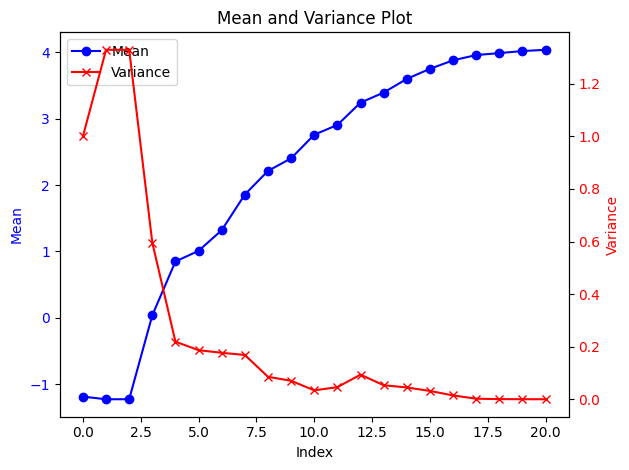

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot means
ax1.plot(means, color='blue', marker='o', label='Mean')
ax1.set_xlabel('Index')
ax1.set_ylabel('Mean', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot variances
ax2 = ax1.twinx()
ax2.plot(variances, color='red', marker='x', label='Variance')
ax2.set_ylabel('Variance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and show the plot
plt.title('Mean and Variance Plot')
fig.tight_layout()  # Adjust layout to prevent overlap

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()